In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.utils import to_categorical

import numpy as np
import h5py
from pathlib import Path
import matplotlib.pyplot as plt

from keras import backend as keras_backend

#y finance stuff
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [2]:
# Stock Module Data
from stock_module4 import download_and_save_stock_data

# Use Symbol for different stocks

symbol = "UPS"
days = 10000
output_csv_path = "stock_data.csv"
download_and_save_stock_data(symbol, days, output_csv_path)

[*********************100%%**********************]  1 of 1 completed
              Open     High      Low  Close  Adj Close    Volume
Date                                                            
1999-11-10  65.000  70.3125  64.5000  68.25  36.707668  80793700
1999-11-11  68.750  76.9375  68.7500  75.00  40.338066  28309000
1999-11-12  76.000  76.6250  69.2500  70.50  37.917797  14768100
1999-11-15  70.500  70.8750  67.3125  69.00  37.111046   8675100
1999-11-16  67.875  68.0000  65.0000  66.00  35.497501   6978600


In [3]:
stock = pd.read_csv('stock_data.csv')
stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-10,65.000000,70.312500,64.500000,68.250000,36.707668,80793700
1,1999-11-11,68.750000,76.937500,68.750000,75.000000,40.338066,28309000
2,1999-11-12,76.000000,76.625000,69.250000,70.500000,37.917797,14768100
3,1999-11-15,70.500000,70.875000,67.312500,69.000000,37.111046,8675100
4,1999-11-16,67.875000,68.000000,65.000000,66.000000,35.497501,6978600
...,...,...,...,...,...,...,...
6057,2023-12-07,155.869995,157.610001,155.500000,156.500000,156.500000,3241200
6058,2023-12-08,156.070007,157.679993,155.960007,156.300003,156.300003,2845900
6059,2023-12-11,155.649994,156.369995,154.839996,155.779999,155.779999,3742100
6060,2023-12-12,155.949997,157.110001,154.919998,155.369995,155.369995,3039900


In [4]:
new_stock = stock[['Date', 'Close']]
new_stock

import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

new_stock['Date'] = new_stock['Date'].apply(str_to_datetime)
new_stock['Date']

new_stock.index = new_stock.pop('Date')
new_stock

<ipython-input-4-e7bfa275337c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_stock['Date'] = new_stock['Date'].apply(str_to_datetime)


,Close
Date,
1999-11-10,68.250000
1999-11-11,75.000000
1999-11-12,70.500000
1999-11-15,69.000000
1999-11-16,66.000000
...,...
2023-12-07,156.500000
2023-12-08,156.300003
2023-12-11,155.779999


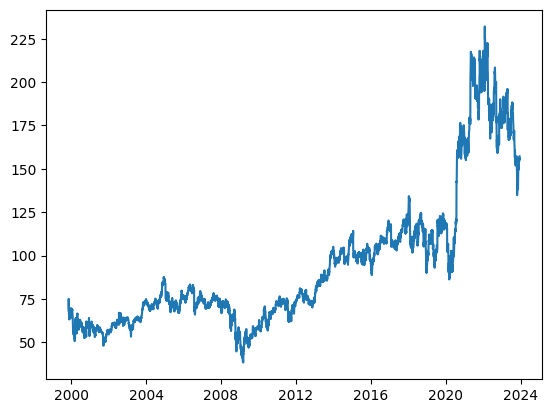

In [5]:
plt.plot(new_stock.index, new_stock['Close'])

In [6]:
df = new_stock

# Data Segmentation
# Sections the data to one part of the dataframe
# Allows for faster modeling and last strain on the machine

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
# Input desired days to see the observation of the predictions
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2023-12-13',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,161.059998,159.860001,159.910004,163.250000
1,2021-03-26,159.860001,159.910004,163.250000,167.979996
2,2021-03-29,159.910004,163.250000,167.979996,168.139999
3,2021-03-30,163.250000,167.979996,168.139999,168.639999
4,2021-03-31,167.979996,168.139999,168.639999,169.990005
...,...,...,...,...,...
681,2023-12-07,155.919998,154.160004,155.289993,156.500000
682,2023-12-08,154.160004,155.289993,156.500000,156.300003
683,2023-12-11,155.289993,156.500000,156.300003,155.779999
684,2023-12-12,156.500000,156.300003,155.779999,155.369995


In [7]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((686,), (686, 3, 1), (686,))

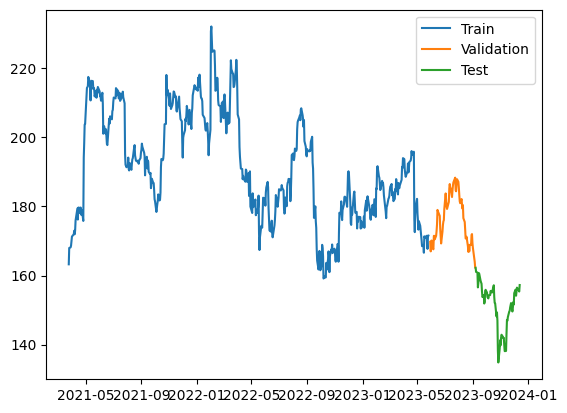

In [8]:
# Train/Test data split
# Sets 80% of data as training data
# Sets 10% as Validation and 10% as testing
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

#plt.title("
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.GRU(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
18/18 [==============================] - 4s 44ms/step - loss: 35715.5391 - mean_absolute_error: 188.3183 - val_loss: 28459.4199 - val_mean_absolute_error: 168.5515
Epoch 2/150
18/18 [==============================] - 0s 8ms/step - loss: 31696.8105 - mean_absolute_error: 177.2720 - val_loss: 22821.9590 - val_mean_absolute_error: 150.9033
Epoch 3/150
18/18 [==============================] - 0s 8ms/step - loss: 22939.8496 - mean_absolute_error: 150.2018 - val_loss: 11599.7051 - val_mean_absolute_error: 107.4558
Epoch 4/150
18/18 [==============================] - 0s 8ms/step - loss: 8688.3164 - mean_absolute_error: 89.0414 - val_loss: 793.3427 - val_mean_absolute_error: 27.2350
Epoch 5/150
18/18 [==============================] - 0s 9ms/step - loss: 701.9687 - mean_absolute_error: 21.5715 - val_loss: 971.7622 - val_mean_absolute_error: 30.3673
Epoch 6/150
18/18 [==============================] - 0s 8ms/step - loss: 393.8557 - mean_absolute_error: 16.5818 - val_loss: 335.9668 -

In [18]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'MAE on Test Set: {loss}')

3/3 [==============================] - 0s 8ms/step - loss: 40.8547 - mean_absolute_error: 5.5663
MAE on Test Set: [40.85466766357422, 5.566327095031738]


18/18 [==============================] - 1s 7ms/step


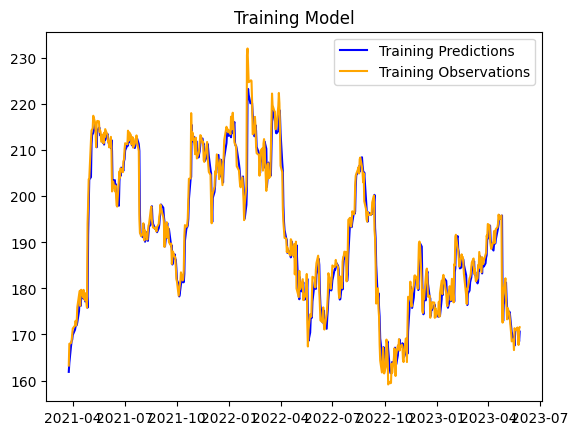

In [11]:
train_predictions = model.predict(X_train).flatten()

plt.title("Training Model")
plt.plot(dates_train, train_predictions, color = 'blue')
plt.plot(dates_train, y_train, color = 'orange')
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 5ms/step


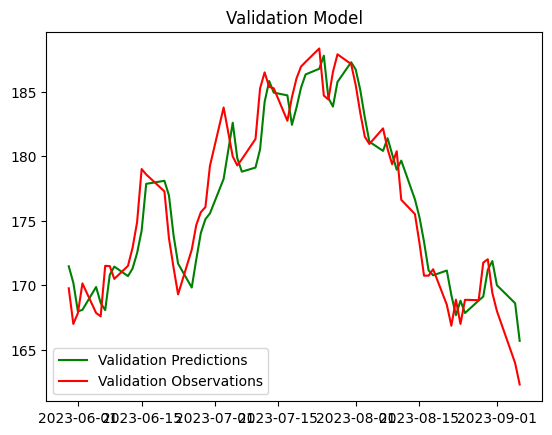

In [12]:
val_predictions = model.predict(X_val).flatten()

plt.title("Validation Model")
plt.plot(dates_val, val_predictions, color = 'green')
plt.plot(dates_val, y_val, color = 'red')
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 5ms/step


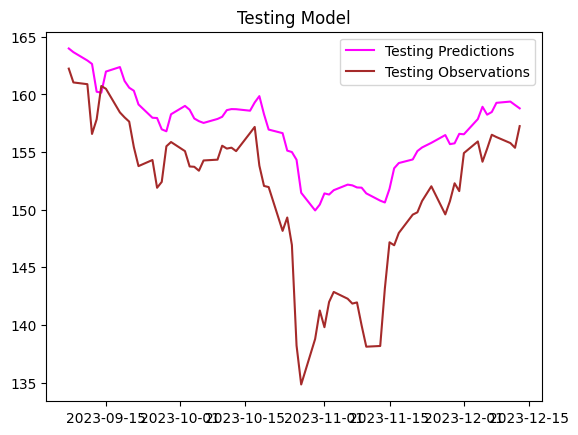

In [13]:
test_predictions = model.predict(X_test).flatten()

plt.title("Testing Model")
plt.plot(dates_test, test_predictions, color = 'magenta')
plt.plot(dates_test, y_test, color = 'brown')
plt.legend(['Testing Predictions', 'Testing Observations'])

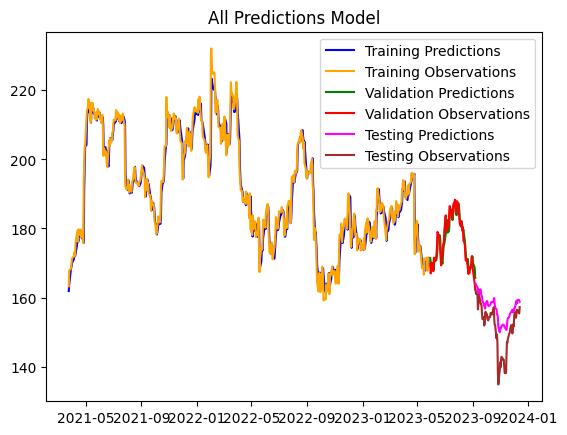

In [14]:
plt.title("All Predictions Model")
plt.plot(dates_train, train_predictions, color = 'blue')
plt.plot(dates_train, y_train, color = 'orange')
plt.plot(dates_val, val_predictions, color = 'green')
plt.plot(dates_val, y_val, color = 'red')
plt.plot(dates_test, test_predictions, color = 'magenta')
plt.plot(dates_test, y_test, color = 'brown')
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [15]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 21ms/step


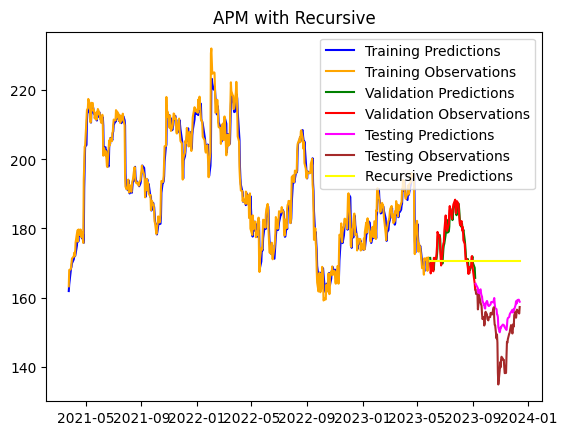

In [16]:
# Plot for Everything

plt.title("APM with Recursive")
plt.plot(dates_train, train_predictions, color = 'blue')
plt.plot(dates_train, y_train, color = 'orange')
plt.plot(dates_val, val_predictions, color = 'green')
plt.plot(dates_val, y_val, color = 'red')
plt.plot(dates_test, test_predictions, color = 'magenta')
plt.plot(dates_test, y_test, color = 'brown')
plt.plot(recursive_dates, recursive_predictions, color = 'yellow')
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])